Mount Google **Drive**

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install memory-profiler


Data Preparation , Data Loading and **Preprocessing**

In [6]:
%load_ext memory_profiler

%memit
# Your code here


# Load and preprocess data

# this is the code for image preprocessing
import cv2
import os
import numpy as np

# Load images from the "correct poses" and "incorrect poses" folders in the drive/MyDrive/Imagedataset path
correct_poses_path = '/content/drive/MyDrive/Imagedataset/sm-correctposes'
incorrect_poses_path = '/content/drive/MyDrive/Imagedataset/sm-incorrectposes'
# correct_poses_path = '/content/drive/MyDrive/Imagedataset/correctposes'
# incorrect_poses_path = '/content/drive/MyDrive/Imagedataset/incorrectposes'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
              # Resizing the images
            img = cv2.resize(img, (256, 256))
            images.append(img)
    return images

correct_images = load_images_from_folder(correct_poses_path)
incorrect_images = load_images_from_folder(incorrect_poses_path)

# Prepare labels for the data set
correct_labels = np.ones(len(correct_images))
incorrect_labels = np.zeros(len(incorrect_images))

# Combine correct and incorrect data
X = np.concatenate((correct_images, incorrect_images), axis=0)
y = np.concatenate((correct_labels, incorrect_labels), axis=0)

# Shuffling data
from sklearn.utils import shuffle
X, y = shuffle(X, y)

# Normalize pixel values
X = X / 255.0

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 121.07 MiB, increment: 0.02 MiB


Model Training

In [7]:
%load_ext memory_profiler

%memit
# Your code here


from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model

# Load MobileNetV2 as base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


peak memory: 4144.31 MiB, increment: 0.11 MiB
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/100
28/28 [==============================] - 76s 3s/step - loss: 0.2386 - accuracy: 0.8846 - val_loss: 0.1456 - val_accuracy: 0.9452
Epoch 2/100
28/28 [==============================] - 69s 3s/step - loss: 0.0632 - accuracy: 0.9794 - val_loss: 0.0619 - val_accuracy: 0.9772
Epoch 3/100
28/28 [==============================] - 72s 3s/step - loss: 0.0356 - accuracy: 0.9954 - val_loss: 0.0365 - val_accuracy: 0.9909
Epoch 4/100
28/28 [==============================] - 70s 3s/step - loss: 0.0229 - accuracy: 0.9966 - val_loss: 0.0283 - val_accuracy: 0.9954
Epoch 5/100
28/28 [==============================] - 72s 3s/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0189 - val_accuracy: 0.9954
Epoch 6/100
28/28 [==============================] - 69s 3s/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9954
Epoch 7/100
28/28 [==========================

In [8]:
from google.colab import files

model.save('Deadlift_Model.h5')

files.download("Deadlift_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model Evaluation

In [9]:
# Evaluate the model using validation data
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


7/7 [==============================] - 20s 3s/step - loss: 0.0015 - accuracy: 1.0000
Validation Loss: 0.0015051229856908321
Validation Accuracy: 1.0


In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np

# Predict classes for validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy:", accuracy)

# Calculate F1 Score
f1 = f1_score(y_true_classes, y_pred_classes)
print("F1 Score:", f1)

# Calculate Precision
precision = precision_score(y_true_classes, y_pred_classes)
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_true_classes, y_pred_classes)
print("Recall:", recall)

# Calculate AUC/ROC Score
roc_auc = roc_auc_score(y_true_classes, y_pred[:, 1])
print("AUC/ROC Score:", roc_auc)


7/7 [==============================] - 14s 2s/step
Confusion Matrix:
[[112   0]
 [  0 107]]
Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0
AUC/ROC Score: 1.0


## **model tested by giving images .model working**

In [46]:
import cv2
from keras.preprocessing import image
import numpy as np

# Example: Performance testing
import time

start_time = time.time()
# Your inference code here

# Load the image from Google Drive
# image_path = '/content/drive/MyDrive/Imagedataset/video/new1.jpg'
# image_path = '/content/drive/MyDrive/Imagedataset/video/IdeadliftImg2.jpg'
image_path = '/content/drive/MyDrive/Imagedataset/video/deadliftImg.jpg'

img = cv2.imread(image_path)
# Resize to match the input shape expected by the model
img = cv2.resize(img, (256, 256))
img = img / 255.0  # Normalize pixel values

# Expand dimensions to create a batch of size 1 (required by the model)
img = np.expand_dims(img, axis=0)

# Making the predictions
predictions = model.predict(img)

# Interpret predictions
class_names = ['Incorrect Pose','Correct Pose']
predicted_class = class_names[np.argmax(predictions)]
# print(predictions)
print("Predicted Class:", predicted_class)


end_time = time.time()

inference_time = end_time - start_time
print("Inference Time:", inference_time)


1/1 [==============================] - 0s 62ms/step
Predicted Class: Incorrect Pose
Inference Time: 0.43645524978637695


**visualising**

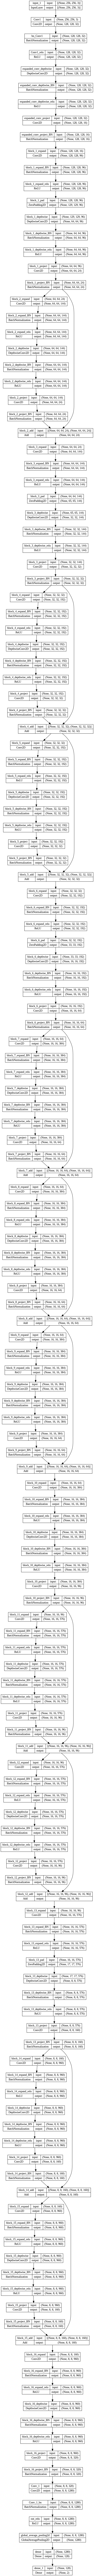

In [16]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [18]:
from google.colab import files

files.download('model_plot.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


NameError: name 'history' is not defined

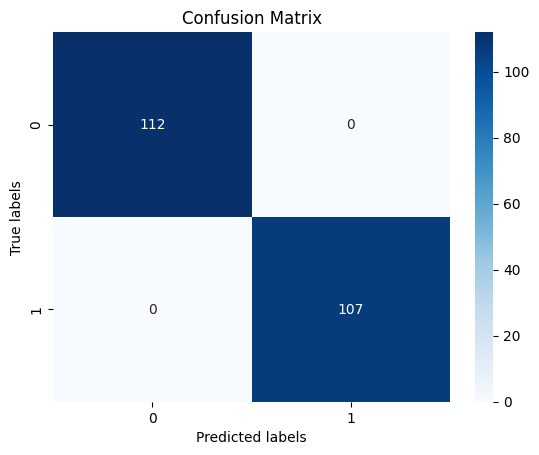

In [20]:
import seaborn as sns

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


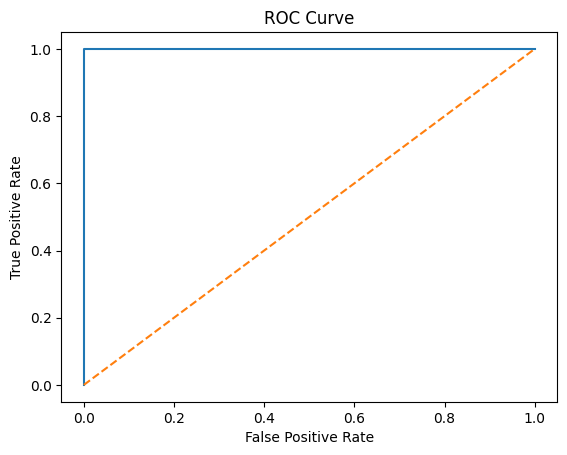

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true_classes, y_pred[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


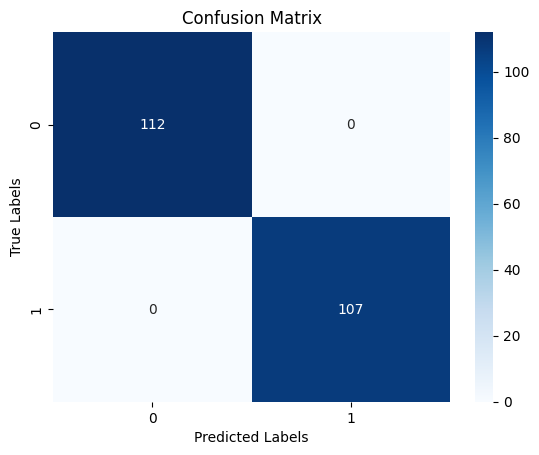

NameError: name 'y_true' is not defined

In [26]:
# Example: Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Example: Plotting precision-recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Example: Displaying feature importance (for tree-based models)
feat_importance = pd.Series(model.feature_importances_, index=X.columns)
feat_importance.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


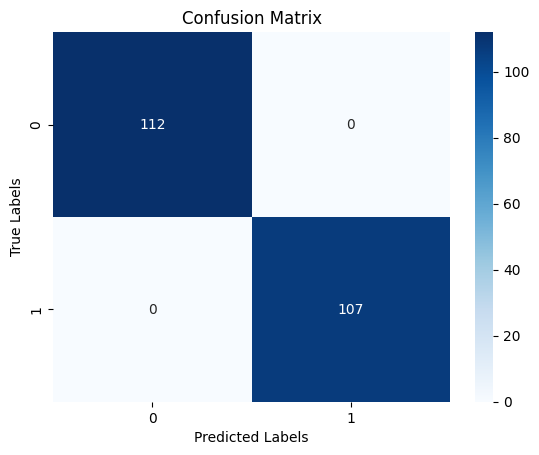

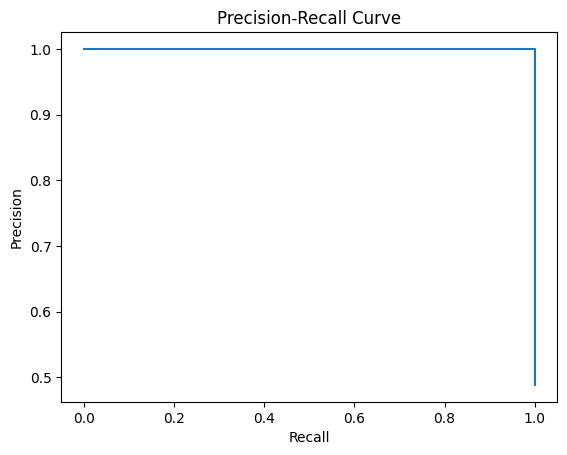

AttributeError: 'Functional' object has no attribute 'feature_importances_'

In [34]:
# Example: Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Assuming y_val is in multi-label format, you need to convert it to binary format
# Convert multi-label y_val to binary format by considering only one class (e.g., class 1)
y_true_binary = y_val[:, 1]  # Assuming class 1 corresponds to index 1

# Example: Plotting precision-recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_true_binary, y_pred[:, 1])  # Use y_pred[:, 1] for class 1
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

import pandas as pd  # Import Pandas module

# Example: Displaying feature importance (for tree-based models)
feat_importance = pd.Series(model.feature_importances_, index=X.columns)
feat_importance.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()



Model Deployment for Real-Time Inference

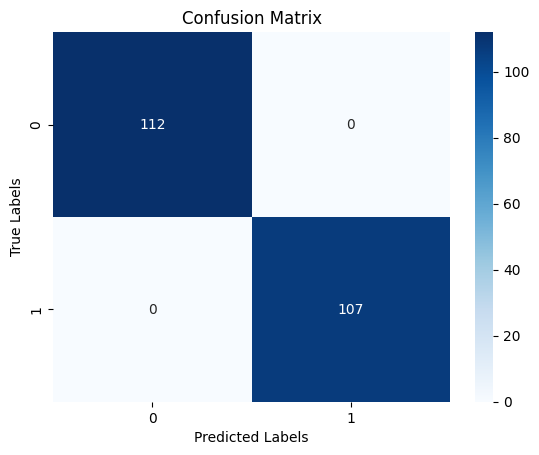

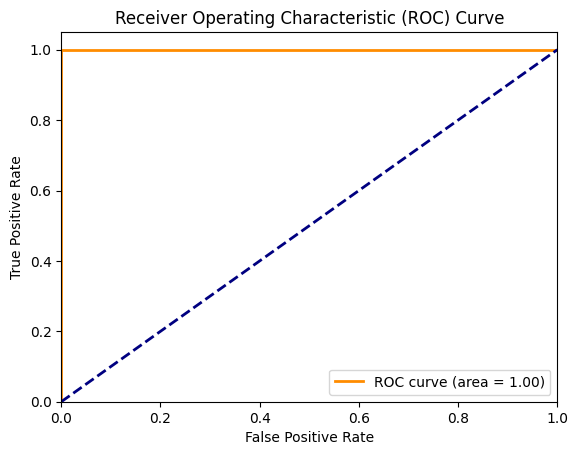

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, RocCurveDisplay

# Confusion Matrix Visualization
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC Curve Visualization
fpr, tpr, _ = roc_curve(y_true_classes, y_pred[:, 1])
roc_auc = roc_auc_score(y_true_classes, y_pred[:, 1])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [47]:
# Save the trained model
model.save('my_model.h5')  # Save as an HDF5 file

# Optionally, if you want to save the model architecture and weights separately:
# Save the model architecture as JSON
model_json = model.to_json()
with open('my_model.json', 'w') as json_file:
    json_file.write(model_json)
# Save the model weights
model.save_weights('my_model_weights.h5')

# Once saved, you can download the model files using your web browser or any other method



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
# Example: Performance testing
import time

start_time = time.time()
# Your inference code here
end_time = time.time()

inference_time = end_time - start_time
print("Inference Time:", inference_time)



Inference Time: 4.5299530029296875e-05
